   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


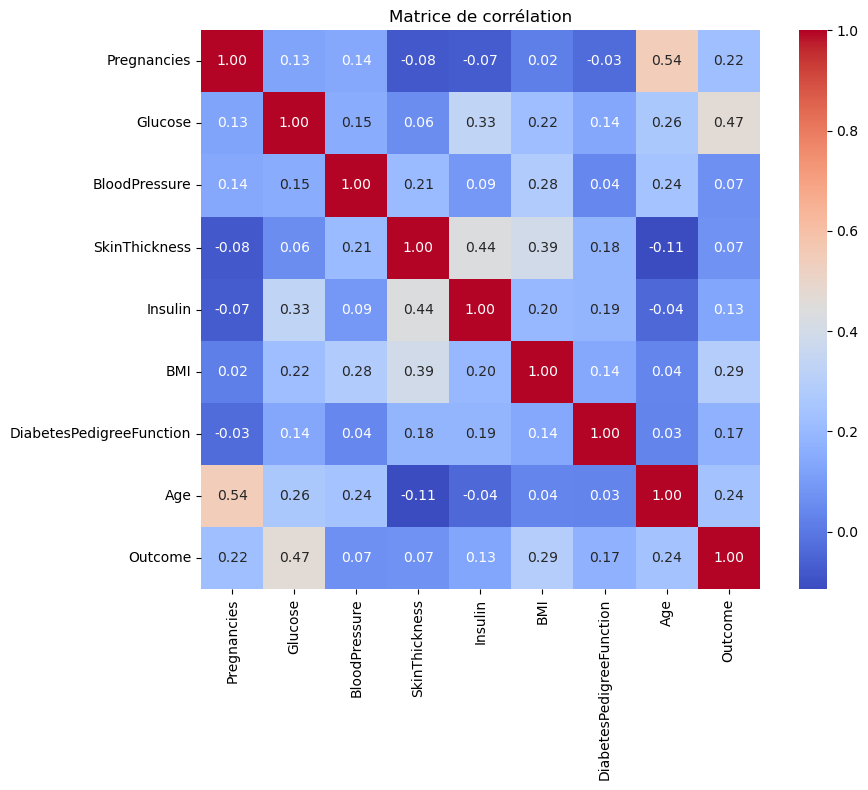

In [2]:
# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# 1. Chargement des données
data = pd.read_csv("diabetes.csv")
print(data.head())
# Affichage de la matrice de corrélation
plt.figure(figsize=(10, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matrice de corrélation')
plt.tight_layout()
plt.show()


Nous avons commencé par charger le jeu de données sélectionné, puis affiché les premières lignes afin d’obtenir un aperçu général de la base. Cette étape exploratoire nous a permis d’identifier les différentes variables (features) disponibles et de mieux comprendre la structure des données. À la suite d’une analyse préliminaire et de quelques visualisations, nous avons constaté que l’ensemble des caractéristiques disponibles étaient pertinentes pour la prédiction. Ainsi, aucune variable n’a été exclue du processus d’apprentissage.

In [5]:
# 2. Remplacement des zéros par NaN dans les colonnes concernées
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[cols_with_zeros] = data[cols_with_zeros].replace(0, np.nan)

# 3. Séparation X / y
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

# 4. Séparation train / test avec stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


Après avoir chargé les données, une première étape de nettoyage est réalisée pour garantir leur qualité. Certaines colonnes biométriques, telles que Glucose, BloodPressure, SkinThickness, Insulin et BMI, peuvent contenir des zéros, qui représentent en réalité des valeurs manquantes. En effet, des mesures comme une glycémie ou une pression artérielle égale à zéro sont médicalement impossibles. Ces zéros sont donc remplacés par des NaN, afin d’être correctement pris en compte par les techniques d’imputation ultérieures.

Une fois les données nettoyées, le jeu est structuré pour l’apprentissage. Les variables explicatives (features) sont regroupées dans X, en excluant la colonne Outcome, tandis que la variable cible y contient les étiquettes indiquant si une personne est diabétique (1) ou non (0). Cette séparation est essentielle pour entraîner un modèle prédictif à partir des caractéristiques des patients.

Enfin, les données sont divisées en deux ensembles : un ensemble d'entraînement (70%) et un ensemble de test (30%) grâce à la fonction train_test_split. Le paramètre stratify=y est utilisé pour conserver la proportion des classes dans chaque sous-ensemble, garantissant ainsi une distribution équilibrée entre les cas diabétiques et non diabétiques, ce qui est crucial lorsque les classes sont déséquilibrées.

In [6]:

# 5. Prétraitement
numeric_features = X.columns
numeric_transformer = Pipeline(steps=[ 
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[ 
        ('num', numeric_transformer, numeric_features)
    ])

Cette partie du code met en œuvre le prétraitement des données numériques avant l'entraînement du modèle. Étant donné que toutes les colonnes du jeu de données sont numériques, elles subissent deux transformations successives regroupées dans un pipeline nommé numeric_transformer.

La première transformation utilise SimpleImputer avec la stratégie de la médiane pour remplacer les valeurs manquantes. Cette méthode est robuste aux valeurs extrêmes et permet de conserver la distribution des données. Ensuite, une standardisation est appliquée avec StandardScaler, qui centre les données (moyenne nulle) et les réduit (écart-type unitaire), afin de garantir que toutes les variables soient sur une même échelle. Cela est crucial pour le bon fonctionnement de nombreux algorithmes, notamment les modèles ensemblistes comme le Gradient Boosting.

Ce pipeline est intégré dans un ColumnTransformer nommé preprocessor, qui applique ces transformations uniquement aux colonnes concernées. Cette approche modulaire facilite l'intégration dans une chaîne de traitement complète et assure un prétraitement structuré, clair et réutilisable.



In [7]:
# 6. Pipeline complet avec GradientBoostingClassifier
pipe_gb = Pipeline([ 
    ('preprocessing', preprocessor),
    ('gb', GradientBoostingClassifier(random_state=42))
])

# 7. GridSearchCV pour tuning des hyperparamètres
param_grid = { 
    'gb__n_estimators': [100, 200, 300],
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [3, 5, 10],
}

grid_search = GridSearchCV(pipe_gb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gb__learning_rate': [0.01, 0.05, 0.1],
                         'gb__max_depth': [3, 5, 10],
                         'gb__n_estimators': [100, 200, 300]},
             scoring='accuracy')

Dans cette section, on construit et optimise une chaîne complète de machine learning en combinant le prétraitement des données et le modèle de classification. Un pipeline nommé pipe_gb est défini, dans lequel deux étapes sont enchaînées : d'abord le prétraitement (preprocessing), qui applique les transformations définies précédemment (imputation et standardisation), puis un classifieur GradientBoostingClassifier, une méthode puissante basée sur l'agrégation d’arbres de décision faibles pour produire un modèle robuste.

Ensuite, l'optimisation des hyperparamètres de ce modèle est réalisée à l’aide de GridSearchCV, une méthode de recherche exhaustive qui teste toutes les combinaisons possibles des paramètres définis dans param_grid. Les paramètres explorés ici sont le nombre d’estimateurs (n_estimators), le taux d’apprentissage (learning_rate) et la profondeur maximale des arbres (max_depth). Pour chaque combinaison, une validation croisée à 5 plis (cv=5) est effectuée, ce qui permet d’évaluer la performance du modèle de façon fiable et non biaisée. Le critère d’évaluation est la précision (accuracy), et le calcul est parallélisé grâce à n_jobs=-1 pour accélérer le processus. Finalement, la méthode fit permet d’entraîner le modèle sur les données d'entraînement (X_train, y_train) tout en sélectionnant automatiquement les meilleurs hyperparamètres trouvés.

Meilleurs hyperparamètres : {'gb__learning_rate': 0.05, 'gb__max_depth': 3, 'gb__n_estimators': 200}

Précision sur le test : 0.7489

Rapport de classification :
               precision    recall  f1-score   support

           0       0.78      0.85      0.82       150
           1       0.67      0.56      0.61        81

    accuracy                           0.75       231
   macro avg       0.73      0.70      0.71       231
weighted avg       0.74      0.75      0.74       231



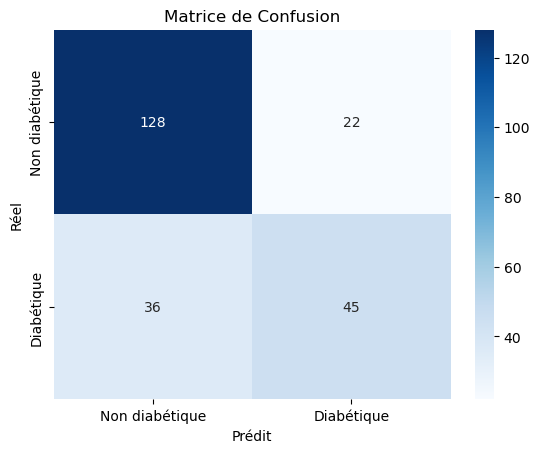

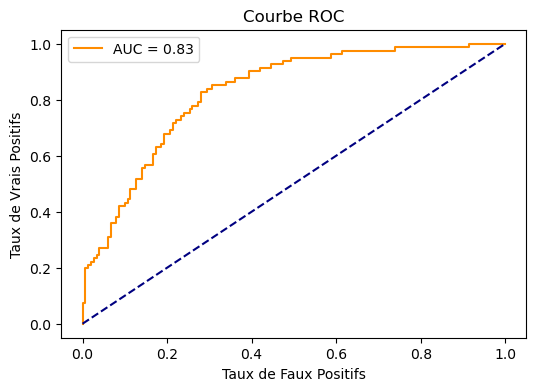


AUC : 0.8279

Précision moyenne en validation croisée : 0.7691 ± 0.0154

RÉSUMÉ FINAL :
- Précision test : 0.7489
- AUC test : 0.8279
- Validation croisée (acc) : 0.7691 ± 0.0154
- Meilleurs hyperparamètres : {'gb__learning_rate': 0.05, 'gb__max_depth': 3, 'gb__n_estimators': 200}


In [8]:
# 8. Meilleurs paramètres
best_model = grid_search.best_estimator_
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# 9. Prédictions
y_pred = best_model.predict(X_test)

# 10. Évaluation du modèle
acc = accuracy_score(y_test, y_pred)
print(f"\nPrécision sur le test : {acc:.4f}")

print("\nRapport de classification :\n", classification_report(y_test, y_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non diabétique', 'Diabétique'], yticklabels=['Non diabétique', 'Diabétique'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# Courbe ROC
probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend()
plt.show()

print(f"\nAUC : {roc_auc:.4f}")

# 11. Validation croisée sur l'ensemble d'entraînement
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nPrécision moyenne en validation croisée : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 12. Résumé final automatique
print("\n\033[1mRÉSUMÉ FINAL :\033[0m")
print(f"- Précision test : {acc:.4f}")
print(f"- AUC test : {roc_auc:.4f}")
print(f"- Validation croisée (acc) : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"- Meilleurs hyperparamètres : {grid_search.best_params_}")


Dans cette partie du code, on commence par extraire le meilleur modèle obtenu grâce à la recherche par grille (GridSearchCV) via best_estimator_, et on affiche les meilleurs hyperparamètres sélectionnés. Ensuite, ce modèle optimisé est utilisé pour faire des prédictions sur l’ensemble de test (X_test), puis la performance du modèle est évaluée à l’aide de plusieurs métriques.

La précision globale sur l’ensemble de test est calculée et affichée avec la fonction accuracy_score. Pour une analyse plus détaillée, un rapport de classification est généré, fournissant les scores de précision, rappel et F1-score pour chaque classe. La matrice de confusion est également construite et visualisée sous forme de heatmap, permettant d’identifier le nombre de vrais positifs, vrais négatifs, faux positifs et faux négatifs, ce qui facilite l’interprétation des erreurs du modèle.

On calcule aussi la courbe ROC (Receiver Operating Characteristic) pour visualiser la capacité du modèle à discriminer entre les classes à différents seuils de décision, et on affiche l’aire sous la courbe (AUC), un indicateur global de performance. Une figure illustrant cette courbe est tracée pour une meilleure compréhension visuelle.

Par ailleurs, une validation croisée à 5 plis est effectuée sur l’ensemble d’entraînement pour estimer la robustesse et la stabilité du modèle. Les scores moyens et leur écart-type sont affichés pour mesurer la variance de la performance.

Enfin, un résumé global des résultats est imprimé, incluant la précision sur le test, l’AUC, les résultats de la validation croisée et les meilleurs hyperparamètres, offrant ainsi une synthèse claire et complète des performances du modèle.

## NOTE ##

Le modèle Gradient Boosting utilisé présente une performance globalement satisfaisante avec une aire sous la courbe ROC (AUC) de 0.8279. Cette valeur élevée indique que le modèle a une bonne capacité à distinguer les patients diabétiques des non-diabétiques, bien qu’il reste encore une marge d’amélioration possible. La précision sur l’ensemble de test atteint 74.89 %, ce qui signifie qu’environ trois quarts des prédictions sont correctes. Cependant, cette précision est légèrement inférieure à celle observée en validation croisée (76.91 %), ce qui pourrait suggérer un léger surajustement du modèle, mais cela reste modéré.

En analysant le rapport de classification, on note que pour la classe 0 (non diabétique), la précision (0.78) et le rappel (0.85) sont bons, ce qui signifie que le modèle identifie efficacement les non-diabétiques tout en limitant les erreurs sur cette classe. En revanche, pour la classe 1 (diabétique), la précision (0.67) et surtout le rappel (0.56) sont plus faibles, indiquant que le modèle a des difficultés à détecter correctement les diabétiques. Cela peut être lié à un déséquilibre des classes ou à une sensibilité insuffisante du modèle aux exemples positifs.

La matrice de confusion illustre clairement ces observations : le modèle classe correctement 128 individus non diabétiques mais commet 22 erreurs (faux positifs). Pour les diabétiques, il reconnaît 36 cas correctement mais en rate 45 (faux négatifs), confirmant un faible rappel et donc une sous-estimation des cas diabétiques.



## AMELIORATION POSSIBLE ## 

Rééchantillonnage : appliquer des techniques d’oversampling pour augmenter les exemples de la classe minoritaire (diabétiques) ou d’undersampling pour réduire la classe majoritaire (non diabétiques).

Utilisation de poids d’échantillons : pénaliser davantage les erreurs sur la classe minoritaire afin d’inciter le modèle à mieux la détecter.

Modèles spécialisés : tester des algorithmes conçus pour gérer le déséquilibre, comme le BalancedRandomForestClassifier, ou utiliser des méthodes d’ensemble avancées telles que XGBoost.
hypereparametrage:
Le paramètre subsample pour augmenter la diversité des arbres,

min_samples_split et min_samples_leaf pour mieux contrôler la régularisation,

max_features pour varier le nombre de caractéristiques considérées à chaque division.

## CONCLUSION ##

Le modèle Gradient Boosting actuel offre de bons résultats globaux mais montre une capacité limitée à détecter correctement les patients diabétiques. Avec une AUC de 0.8279 et une précision de 74.89 %, il fonctionne bien, mais un travail d’amélioration est nécessaire, en particulier pour mieux gérer le déséquilibre des classes et augmenter le rappel pour la classe 1. La mise en œuvre de techniques de rééchantillonnage, l’ajustement des poids, l’optimisation fine des hyperparamètres, voire le recours à des modèles alternatifs, permettraient d’améliorer significativement la détection des diabétiques et la performance globale du modèle.